#### Visualisations for the data

In [1]:
import os
import yaml
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from windrose import WindroseAxes #noqa: E402

plt.rcParams["font.family"] = "monospace"

wd = "hazGAN2/projects/poweruk_winter"

with open(os.path.join(wd, "config.yaml"), "r") as stream:
    config = yaml.safe_load(stream)


regions = ["East Midlands", "West Midlands", "South West England", "South Wales"]
region_of_interest = regions[0]

season = config["sfunc"]
local_crs = config["local_crs"]

ERROR 1: PROJ: proj_create_from_database: Open of /hn01-home/spet5107/micromamba/envs/hazGAN/share/proj failed


Look at the DNO license regions.

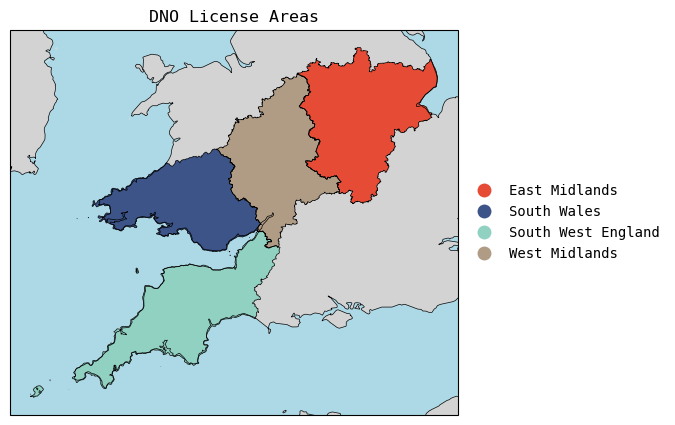

In [2]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(["#E64B35", "#4DBBD5", "#00A087", "#3C5488", "#F39B7F", "#8491B4", "#91D1C2", "#DC0000", "#7E6148", "#B09C85"], name='npg')

dno_path = os.path.join(wd, "resources", "dno_license_areas.geojson")

dno_regions_uk = gpd.read_file(dno_path)
dno_regions = dno_regions_uk[dno_regions_uk["region"].isin(regions)]
bbox = dno_regions.total_bounds

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(6, 5))

dno_regions.boundary.plot(color="k", ax=ax, linewidth=0.5)
dno_regions.plot("region", ax=ax, categorical=True, legend=True, cmap=cmap,
                 legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "frameon": False})
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

ax.set_title("DNO License Areas");

fig.savefig(os.path.join(wd, "results", "figures", "dno_regions"), dpi=300, transparent=True)

In [79]:
train = xr.open_dataset(os.path.join(wd, "results", "training", "data.nc"))
gener = xr.open_dataset(os.path.join(wd, "results", "generated", "netcdf", "data.nc"), engine="netcdf4")
gener.load() # do the expensive server load once
print(gener.sizes)

Frozen({'time': 14100, 'lat': 64, 'lon': 64, 'field': 3, 'param': 6})


In [88]:
dataset = ["training", "generated"][1]
data = train.copy() if dataset == "training" else gener.copy()

In [89]:
medians = train["medians"].mean(dim="month")
medians = medians.to_dataset(name="medians")

In [90]:
def direction(
        ds:xr.Dataset, u:str, v:str,
        params={}
        ) -> xr.DataArray:
    u = ds[u]
    v = ds[v]
    direction = (180 + 180 / np.pi * xr.ufuncs.arctan2(v, u)) % 360
    return direction


def derive_variables(ds):
    ds["vx"] = xr.ufuncs.hypot(ds.u10, ds.v10)
    ds["dx"] = direction(ds, "u10", "v10")
    return ds


data["u10"] = data.sel(field="u10_gust").anomaly
data["v10"] = data.sel(field="v10_gust").anomaly
data["r30"] = data.sel(field="r30").anomaly

medians["u10"] = medians.sel(field="u10_gust").medians
medians["v10"] = medians.sel(field="v10_gust").medians
medians["r30"] = medians.sel(field="r30").medians

print("Deriving variables...")
data = derive_variables(data)
medians = derive_variables(medians)

# assign units to variables
data.vx.attrs["units"] = "m/s"
data.dx.attrs["units"] = "Δ°"
data.r30.attrs["units"] = "m"

# assign long names to variables
data.vx.attrs["long_name"] = "10m gust speed"
data.dx.attrs["long_name"] = "10m wind direction anomaly"
data.r30.attrs["long_name"] = "30-day accumulated precipitation"

Deriving variables...


Plot a windrose of the deviations before making the final analysis variables.

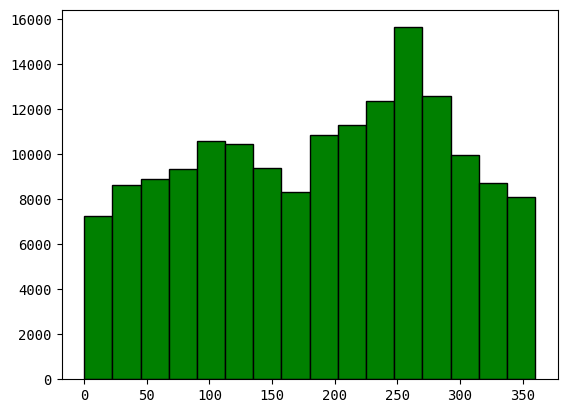

In [91]:
# look at the raw wind direction histogram (to verify wind rose against)
plt.hist(dirs, bins=16, color="green", edgecolor="k");

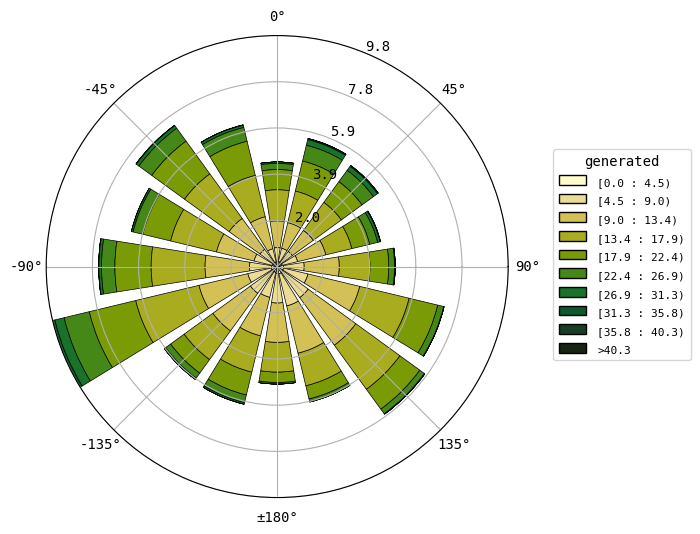

In [92]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='windrose'))

# subset to bbox
data_wr = data.sel(
    lon=slice(bbox[0], bbox[2]),
    lat=slice(bbox[1], bbox[3])
    )

dirs = data_wr.dx.values.flatten()
speeds = data_wr.vx.values.flatten()

ax.bar(dirs, speeds, normed=True,
       opening=0.8, edgecolor='black',
       nsector=16, bins=10,
       cmap=cmo.speed, linewidth=0.5)

ax.set_legend(bbox_to_anchor=(1.1, 0.3), title=dataset)

ax.set_xticklabels(['90°', '45°',  '0°', '-45°', '-90°', '-135°','±180°', '135°']);

fig.savefig(os.path.join(
    wd, "results", "figures", f"windrose_{region_of_interest.lower()}_{season}_{dataset}.png"),
    bbox_inches="tight", transparent=True, dpi=300)

For the final analysis, we want the absolute $r^{30}$ and $v^X$ values, so add back the climatology. For wind anomaly, we want the absolute deviation $\in [0,180)^{\circ}$ from climatology so don't need to add it back.

In [93]:
# convert anomalies to analysis-ready
data["vx"] += medians["vx"]
data["dx"] = (data["dx"] - 180).__abs__()
data["r30"] += medians["r30"]

In [ ]:
"""
Script from original slides.
"""


# %% plot aggregate statistics
agg_func = ["mean", "median", "min", "max"][1]

data_agg = getattr(data, agg_func)(dim="time")
fig, axs = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})

ax = axs[0]
data_agg.vx.plot(
    ax=ax, cmap=cmo.speed,
    cbar_kwargs={"label": "mean gust speed (m/s)", "shrink": 0.6}
    )
data_agg.plot.streamplot(
    x='lon', y='lat', u='u10', v='v10',
    transform=ccrs.PlateCarree(), color="white", ax=ax, density=1.5,
    linewidth=0.5, arrowstyle='->', arrowsize=2
    )
gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.25)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_title("Mean wind speed and direction")

ax = axs[1]
data_agg.r30.plot(
    ax=ax, cmap=cmo.rain,
    cbar_kwargs={"label": "30-day rainfall (m)", "shrink": 0.6}
    )
gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.25)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_title("Mean 30-day antecedent rainfall")

fig.suptitle(f"{agg_func.capitalize()} {dataset.lower()}", fontsize=16, y=0.85)
plt.tight_layout()

# %% 
data_agg = data.std(dim="time")
fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

ax = axs[0]
data_agg.dx.plot(
    ax=ax, cmap=cmo.speed,
    vmin=60, vmax=120,
    cbar_kwargs={"label": "direction (m/s)", "shrink": 0.6}
    )
gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.25)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_title("Wind direction")

ax = axs[1]
data_agg.vx.plot(
    ax=ax, cmap=cmo.speed,
    vmin=2.5, vmax=5.5,
    cbar_kwargs={"label": "gust speed (m/s)", "shrink": 0.6}
    )
gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.25)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_title("Wind speed")

ax = axs[2]
data_agg.r30.plot(
    ax=ax, cmap=cmo.rain,
    vmin=0.02, vmax=0.14,
    cbar_kwargs={"label": "30-day rainfall (m)", "shrink": 0.6}
    )
gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.25)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_title("30-day antecedent rainfall")

fig.suptitle(f"Std {dataset.lower()}", fontsize=16, y=0.85)
plt.tight_layout()

# %% plot scatter plots for directon of specific locations in NE and SE
locations = {
    "North Sea": {"lon": 0.71512, "lat": 57.5237},
    "English Channel": {"lon": -0.2522, "lat": 50.3990}
}


fig, axs = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey=True)

for i, (loc, coords) in enumerate(locations.items()):
    data_t = data.sel(lon=coords["lon"], lat=coords["lat"], method="nearest")
    ax = axs[0, i]
    speed = ax.scatter(data_t.u10, data_t.v10,
               c=data_t.vx, cmap=cmo.speed,
               s=10)
    fig.colorbar(speed, ax=ax, label="max gust speed (m/s)", shrink=0.6)
    
    ax = axs[1, i]
    dir = ax.scatter(data_t.u10, data_t.v10,
               c=data_t.dx, cmap="twilight_shifted",
               vmin=0, vmax=360,
               s=10)
    fig.colorbar(dir, ax=ax, label="direction (degrees)", shrink=0.6)
    
    for ax in axs[:, i]:
        ax.set_xlabel("u10")
        ax.set_ylabel("v10")
        ax.set_title(f"{loc}")
        ax.axhline(0, color='k', lw=0.5, alpha=0.1)
        ax.axvline(0, color='k', lw=0.5, alpha=0.1)

        m, b = np.polyfit(data_t.u10, data_t.v10, 1)
        ax.plot(data_t.u10, m * data_t.u10 + b,
                color="k", lw=0.75, alpha=0.75)
    
        ax.label_outer()


# %%
config["longitude"] # {'min': -10.875, 'max': 5.125}
config["latitude"] # {'min': 49.0, 'max': 64.75}

# %%
t = int(np.random.choice(range(data.sizes["time"]), 1)[0])

print(f"Selected time step: {t}")

data_t = data.isel(time=t)

resample = data_t.isel(lon=slice(None, None, 7), lat=slice(None, None, 7))

fig, axs = plt.subplots(1, 2, figsize=(18, 10), subplot_kw={"projection": ccrs.PlateCarree()})


ax = axs[0]
data_t.vx.plot(
    ax=ax, cmap=cmo.speed,
    cbar_kwargs={"label": "max gust speed (m/s)", "shrink": 0.6}
    )
data_t.plot.streamplot(
    x='lon', y='lat', u='u10', v='v10', 
    transform=ccrs.PlateCarree(), color="white", ax=ax, density=1.5,
    linewidth=0.5, arrowstyle='->', arrowsize=2
    )

gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.5)

ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax.set_title("Wind speed and direction")

ax = axs[1]
data_t.r30.plot(
    ax=ax, cmap=cmo.rain,
    cbar_kwargs={"label": "30-day rainfall (m)", "shrink": 0.6}
    )
gdf_subset.boundary.plot(color="k", ax=ax, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.25)
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])
ax.set_title("30-day antecedent rainfall")

fig.suptitle(f"{dataset.capitalize()} wind and rainfall for {t=}", fontsize=16, y=0.85)

plt.tight_layout()
# %%
"""
def calculate_nimgs(wildcards, years_of_samples=config["nyears"]):
    with zipfile.ZipFile(os.path.join(TRAINING_DIR, "images.zip"), 'r') as zip_ref:
        img_files = [f for f in zip_ref.namelist() if f.lower().endswith(('.png', '.jpg', '.jpeg', '.npy'))]
        nimgs = len(img_files)
    nyears = YEARN - YEAR0
    freq   = nimgs / nyears
    nsamples = int(freq * years_of_samples)
    print(f"Calculated number of samples: {nsamples} based on {nimgs} images over {nyears} years.")
    return nsamples

years_of_samples = 50
nyears = 2018 - 2004 + 1 = 15
nimgs = 429
freq = 429 / 15 = 28.6
nsamples = 28.6 * 50 = 1430
"""